VaR definition: Value at Risk refers to the maximum possible loss of a financial asset or securities portfolio's value within a specific time period, given a certain probability level (confidence level). A 1-day 5% VaR can be understood as the probability of experiencing a loss exceeding the VaR in one day being less than or equal to 5%.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pyplot as plt

# Historical Method

In [10]:
# Define the list of stock codes to be collected
stock_list = ['AAPL']

# Set the time range
start_date = '2020-01-01'
end_date = '2022-04-16'

# Collect stock data using the yfinance module
data = yf.download(stock_list, start=start_date, end=end_date)

# Print the collected stock data
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449387,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735321,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314888,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970085,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143906,132079200
...,...,...,...,...,...,...
2022-04-08,171.779999,171.779999,169.199997,170.089996,169.065857,76575500
2022-04-11,168.710007,169.029999,165.500000,165.750000,164.751984,72246700
2022-04-12,168.020004,169.869995,166.639999,167.660004,166.650482,79265200


In [11]:
data['returns'] = data['Adj Close'].pct_change()

In [22]:
VaR_1_historical = np.percentile(data.returns.dropna(), 1)
VaR_5_historical = np.percentile(data.returns.dropna(), 5)
VaR_1_historical, VaR_5_historical

(-0.06395622957651884, -0.032319448491762076)

Text(0, 0.5, 'count')

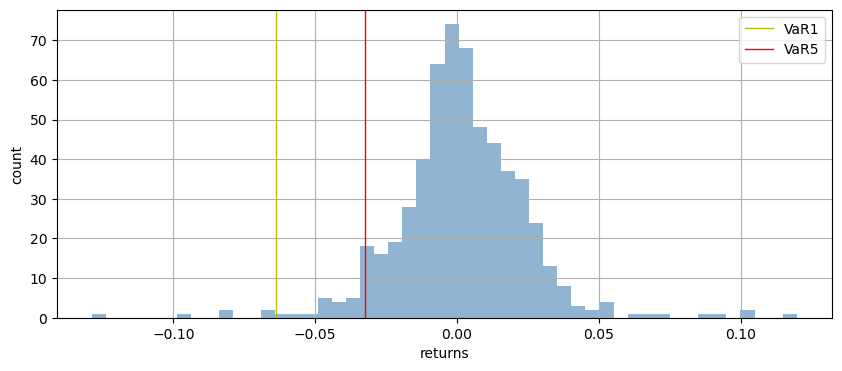

In [277]:
plt.figure(figsize=(10, 4))
data.returns.hist(bins=50, alpha=0.6, color='steelblue')
plt.axvline(VaR_1_historical, color='y', linewidth=1, label='VaR1')
plt.axvline(VaR_5_historical, color='r', linewidth=1, label='VaR5')
plt.legend()
plt.xlabel('returns')
plt.ylabel('count')

# Parameter Method

In [20]:
mean_returns = data.returns.mean()
std = data.returns.std()
VaR_1_param = mean_returns - 2.33*std
VaR_5_param = mean_returns - 1.645*std

In [21]:
VaR_1_param, VaR_5_param

(-0.05212261070053119, -0.036309658624230044)

# Resample Method

In [25]:
def resample_VaR(data, size):
    sample = np.random.choice(data, size, replace=True)
    VaR_1_resample = np.percentile(sample, 1)
    VaR_5_resample = np.percentile(sample, 5)
    return VaR_1_resample, VaR_5_resample

In [27]:
data_pool = data.returns.dropna()
resample_VaR(data_pool, 300)

(-0.047660319916341044, -0.03247033537568431)

In [29]:
samples = [resample_VaR(data_pool, 300) for i in range(100)]
df = pd.DataFrame(samples, columns=['VaR_1', 'VaR_5'])
df.mean()

VaR_1   -0.060783
VaR_5   -0.031953
dtype: float64

# Monte Carlo

Monte Carlo simulation principle: Assuming that stock price fluctuations follow the geometric Brownian motion, 

S_t = S_(t-1) + S_(t-1)(μdt + σε√dt)

, where S_t is today's stock price, S_(t-1) is the stock price of the previous day, μ is the average daily return of the stock, ε is a random term following the standard normal distribution, and dt is the simulation time interval. For example, if you simulate the stock price once a day, dt = 1; if you simulate it twice a day, dt = 0.5; if you simulate it once every ten days, dt = 10. Using yesterday's stock data as the initial data and the historical data's daily average return and volatility in the formula, you can simulate the stock price after one day 100 times, obtaining 100 return data points. Then, calculate the 95% and 99% percentiles of these 100 return rates to obtain the 95% and 99% VaR.

In [235]:
def calculate_var(start_price, prices, alpha):
    """
    prices: NumPy array, including the simulated stock price path
    alpha: float, confidence level

    Return a float, representing the VaR at the given confidence level.
    """
    # calc returns
    returns = prices / start_price - 1

    # calc VaR
    var = np.percentile(returns, 100 - alpha)

    return var

In [236]:
def geometric_brownian_motion(S, mu, sigma, dt, T, limit=0.1):
    """
    Generate a stock price path using geometric Brownian motion

    S: float, initial stock price
    mu: float, average return rate
    sigma: float, volatility
    dt: float, time interval
    T: int, total number of simulation time steps

    Returns a NumPy array representing the simulated stock price path
    """
    # Calculate the total number of simulation steps
    N = int(T / dt)

    # Create a NumPy array of shape (N+1,) for storing the simulated stock price path
    prices = np.zeros(N+1)

    # Assign the initial price to the first price of the simulation
    prices[0] = S

    # Generate random terms following the standard normal distribution
    epsilon = np.random.randn(N)

    # Generate the stock price path
    for i in range(1, N+1):
        drift = mu * dt
        diffusion = sigma * epsilon[i-1] * np.sqrt(dt)
        prices[i] = prices[i-1] + prices[i-1] * (drift + diffusion)

        # price limitation
        max_price = prices[i-1] * (1 + limit)
        min_price = prices[i-1] * (1 - limit)
        prices[i] = max(prices[i], min_price)
        prices[i] = min(prices[i], max_price)

    return prices

In [237]:
def monte_carlo_simulation(S, mu, sigma, dt, T, n_simulations=1000):
    """
    Generate multiple stock price paths using Monte Carlo simulation and calculate VaR.

    S: float, initial stock price
    mu: float, average rate of return
    sigma: float, volatility
    dt: float, time interval
    T: int, total number of time steps to simulate
    limit: float, limit of upper and lower price fluctuations, default to 10%
    alpha: float, confidence level, default to 95%
    n_simulations: int, number of stock price paths to simulate, default to 1000

    Return a float, representing the VaR at the given confidence level.
    """
    # Generate n_simulations stock price paths.
    simulations = []
    for i in range(n_simulations):
        prices = geometric_brownian_motion(S, mu, sigma, dt, T, limit=0.1)
        simulations.append(prices)

    # Calculate the ending price of each stock price path.
    final_prices = np.array([s[-1] for s in simulations])

    # calculate VaR
    var = calculate_var(S, final_prices, alpha=95)

    return var

In [269]:
S = data['Adj Close'].iloc[-1]
mu = data.returns.mean()
sigma = data.returns.std()

In [276]:
monte_carlo_simulation(S=S, mu=mu, sigma=sigma, dt=1, T=60, n_simulations=10000)

-0.18965045918967122